# Source Finders in opticam_new

`opticam_new` uses `photutils` to find sources in images. This notebook will demonstrate how to define source finders for use with `opticam_new`, as well as explain `opticam_new`'s default behaviour when no source finder is specified.

## Test Image

First thing's first, let's open an image that contains some sources. For this example, I'll use one of hte images from the [Basic Usage tutorial](basic_usage.ipynb):

In [1]:
from astropy.io import fits
import numpy as np

with fits.open("Data/g-band_image_0.fits") as hdul:
    print(repr(hdul[0].header))
    image = np.array(hdul[0].data)
    binning_factor = int(hdul[0].header['BINNING'][0])

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  256                                                  
NAXIS2  =                  256                                                  
EXTEND  =                    T                                                  
FILTER  = 'g       '                                                            
BINNING = '8x8     '                                                            
GAIN    =                  1.0                                                  
UT      = '2024-01-01 00:00:00'                                                 


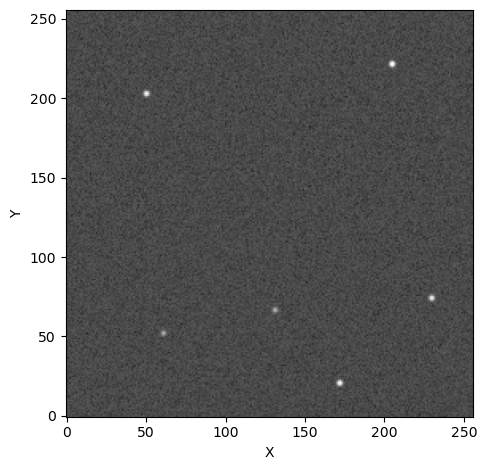

In [2]:
from astropy.visualization import simple_norm
from matplotlib import pyplot as plt

fig, ax = plt.subplots(tight_layout=True)

im = ax.imshow(image, norm=simple_norm(image, stretch="sqrt"), origin="lower", cmap="Greys_r")

ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.show()

## Default Finder

`opticam_new` implements two default source finders: `Finder` and `CrowdedFinder`. `Finder` does not implement any source deblending, while `CrowdedFinder` does, making it better-suted to crowded images. Source deblending incurs a small computational expense, and only necessary in crowded fields or cases when there are multiple sources close together; as such, `opticam_new` will default to `Finder`. Let's use `Finder` to identify the sources in the above image:

In [3]:
from opticam_new import Finder

from photutils.segmentation import detect_threshold

default_finder = Finder(npixels=128 // binning_factor**2, border_width=64 // binning_factor)  # default values 

default_segm = default_finder(image, threshold=detect_threshold(image, nsigma=5))  # detect sources above 5 sigma
print(type(default_segm))

<class 'photutils.segmentation.core.SegmentationImage'>


When calling `opticam_new.Finder()`, a `SegmentationImage` is returned:

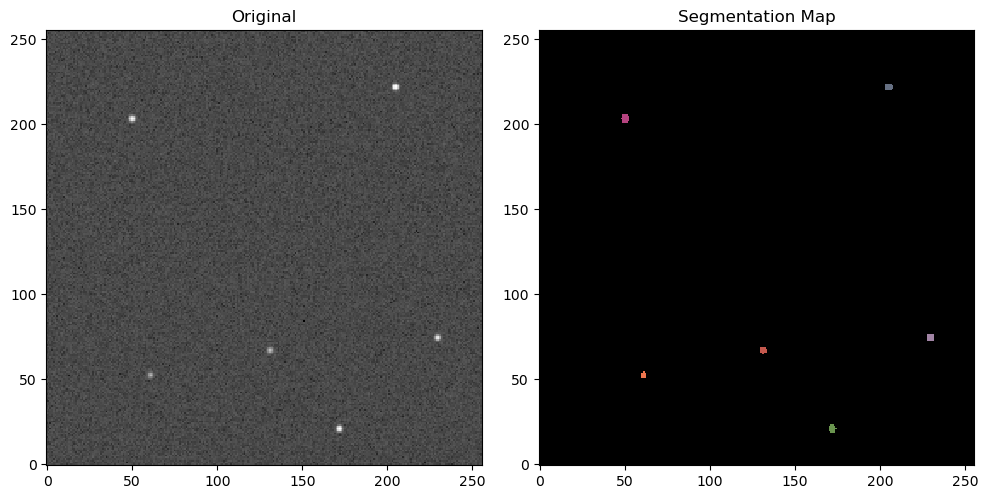

In [4]:
fig, axs = plt.subplots(ncols=2, tight_layout=True, figsize=(10, 5))

axs[0].set_title("Original")
axs[0].imshow(image, norm=simple_norm(image, stretch="sqrt"), origin="lower", cmap="Greys_r", interpolation='nearest')

axs[1].set_title("Segmentation Map")
axs[1].imshow(default_segm, origin="lower", cmap=default_segm.cmap, interpolation="nearest")

plt.show()

As we can see, all the sources have been correctly identified. We could equally have used the `CrowdedFinder` instead, though this is not necessary in this case:

In [5]:
from opticam_new import CrowdedFinder

crowded_finder = CrowdedFinder(npixels=128 // binning_factor**2, border_width=64 // binning_factor)

crowded_segm = default_finder(image, threshold=detect_threshold(image, nsigma=5))

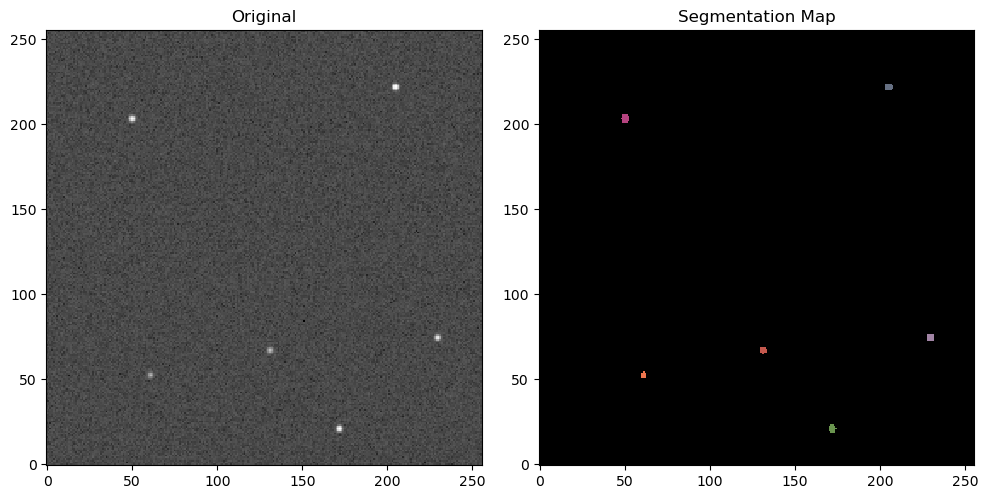

In [6]:
fig, axs = plt.subplots(ncols=2, tight_layout=True, figsize=(10, 5))

axs[0].set_title("Original")
axs[0].imshow(image, norm=simple_norm(image, stretch="sqrt"), origin="lower", cmap="Greys_r", interpolation='nearest')

axs[1].set_title("Segmentation Map")
axs[1].imshow(crowded_segm, origin="lower", cmap=crowded_segm.cmap, interpolation="nearest")

plt.show()

## Custom Source Finders

### Defining the Source Finder

Let's now define a custom source finder. To implement a custom source finder, we can inherit from the `Finder` base class, which implements the required `__call__()` method for us, or we can implement the `__call__()` method ourselves. The `__call__()` method must take two parameters: `image` and `threshold`. `image` should be an `NDArray` containing the image data. `threshold` defines the threshold for source detection, typically defined in units of the background RMS. In this case, we will not inherit from the `Finder` base class and will implement the `__call__()` method ourselves:

In [7]:
from photutils.segmentation import SourceFinder

class CustomFinder(SourceFinder):
    
    def __init__(self, border_width = 0, **kwargs):
        
        self.border_width = border_width
        
        self.finder = SourceFinder(**kwargs)
    
    def __call__(self, image, threshold):
        
        segment_map = self.finder(image, threshold)
        segment_map.remove_border_labels(border_width=self.border_width, relabel=True)
        
        return segment_map

This source finder is basicaly a wrapper for the `SourceFinder` class from `photutils`. It has all the same functionality, but takes an additional `border_width` parameter. It also implements a custom `__call__()` method that identifies sources and removes source labels close to the edge of the image. Let's initialise this custom source finder and use it to identify sources in the above image:

In [8]:
custom_finder = CustomFinder(npixels=128 // binning_factor**2, border_width=64 // binning_factor, deblend=True,
                             nlevels=256, contrast=0, progress_bar=False)

custom_segm = custom_finder(image, threshold=detect_threshold(image, nsigma=5))

Let's plot the image to see what it looks like:

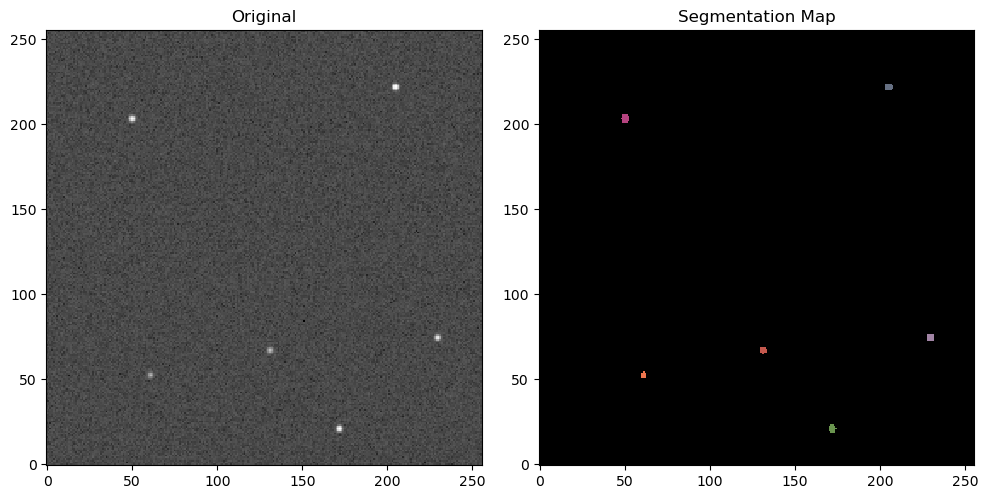

In [9]:
fig, axs = plt.subplots(ncols=2, tight_layout=True, figsize=(10, 5))

axs[0].set_title("Original")
axs[0].imshow(image, norm=simple_norm(image, stretch="sqrt"), origin="lower", cmap="Greys_r", interpolation='nearest')

axs[1].set_title("Segmentation Map")
axs[1].imshow(custom_segm, origin="lower", cmap=custom_segm.cmap, interpolation="nearest")

plt.show()

As we can see, we have once again recovered all six sources. For more information on defining custom source finders, I refer to the excellent `photutils` documentation: https://photutils.readthedocs.io/en/stable/segmentation.html.

That concludes the source finder tutorial for `opticam_new`! Much of the heavy lifting here is handled by `photutils`, so I'd highly recommend checking out their documentation for more information source detection using image segmentation.